<h1 style="text-align: center;" markdown="1">Complex Networks - Practical Session</h1>
<h3 style="text-align: center;" markdown="1">by Dimitri Lajou and Fabrice Lebeau</h3>

## Introduction
In this notebook, we present a (small) graph library that implements some useful function about graphs, e.g. shortest paths, components etc. We then apply some of these functions to the classical Zachary graph and two random graphs with 100 and 1000 nodes.

Let us first import the tools we are going to use.

In [3]:
import numpy
import math
from parse import parse
from IPython.display import Math, Markdown, Latex, display, display_latex, SVG

## The Graph class
### Basics
We consider *undirected* graphs $G=(V,E)$, that we store in an adjacency list (we use a map $V \rightarrow \mathcal{P}(V)$ which assign to node $v \in V$ the list of nodes which are linked to $v$). We begin by adding the functions for defining a graph from a map, for adding vertices/edges and for retrieving the set of edges and vertices of the G. Other functions are presented in the rest of this notebook.

We also define static methods `clique` and `no_edges` which respectively returns an instance of Graph corresponding to a clique of the desired size and a completely disconnected graph with given number of nodes. These examples will come handy for debugging.

In [4]:
""" CR15 graph library """
class Graph(object):

    def __init__(self, graph_dict={}):
        """ initializes a graph object """
        self.__graph_dict = graph_dict.copy()

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()
    
    def connected_components(self):
        return self.__generate_components()

    def add_vertex(self, vertex):
        """ If vertex is not in self.__graph_dict, a key "vertex" with an empty
        list as a value is added to the dictionary. Otherwise nothing has to be 
        done. To complete."""
        if not vertex in self.__graph_dict:
            self.__graph_dict[vertex] = []
        

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list. No loops or 
        multiple edges. To complete."""
        my_edge = list(edge)
        if len(my_edge) != 2: raise WrongSizeForEdge()
        u = edge.pop()
        v = edge.pop()
        if u in self.__graph_dict and v in self.__graph_dict:
            if u != v:
                if v not in self.__graph_dict[u]:
                    self.__graph_dict[u].append(v)
                if u not in self.__graph_dict[v]:
                    self.__graph_dict[v].append(u)
        else:
            raise VerticesNotDecleared()
            

    def __generate_edges(self):
        """ A static method generating the edges of the graph "graph". Edges 
        are represented as sets two vertices, with no loops. To complete."""
        edges = []
        for v, edges_list in self.__graph_dict.items():
            for u in edges_list:
                if v < u:
                    edges.append(set([v,u]))
        return edges
    
    def vertex_degrees(self):
        """Return a dictionary degree"""
        degrees = {}
        for v, edges_list in self.__graph_dict.items():
            degrees[v] = len(edges_list)
        return degrees
    
    def vertex_degree(self, vertex):
        """Return a dictionary degree"""
        return len(self.__graph_dict[vertex])
    
    def find_isolated_vertices(self):
        zero_set = set()
        for v, edges_list in self.__graph_dict.items():
            if len(edges_list) == 0:
                zero_set.add(v)
        return zero_set
                
    def density(self):
        deg = self.vertex_degrees()
        density = 0
        for v, d in deg.items():
            density += d
        density /=  (len(deg) -1) *len(deg)
        return density
                    
    def dict(self):
        return self.__graph_dict
    
    def degree_sequence(self):
        deg = self.vertex_degrees()
        deg_list = [v for v in deg.values()]
        deg_list.sort(reverse=True)
        return tuple(deg_list)
    
    @staticmethod
    def erdos_gallai(deg_seq):
        #deg_seq = self.degree_sequence()
        even_number = 0
        for v in deg_seq:
            even_number += v
        if even_number % 2 == 1 :
            return False
        sumOfdi = 0
        for k in range(len(deg_seq)):
            sumOfdi += deg_seq[k]
            sumOfMin = k*(k+1)
            for i in range(k, len(deg_seq)):
                sumOfMin += min(deg_seq[i], k+1)
            if sumOfMin < sumOfdi:
                return False
        return True
    
    def global_clustering_coefficient(self):
        triangle = 0
        triplet = 0
        for v in self.__graph_dict:
            for u in self.__graph_dict[v]:
                for w in self.__graph_dict[v]:
                    if u != w: 
                        triplet += 1
                    if u != w and w in self.__graph_dict[u]:
                        triangle += 1
        return triangle / triplet
    
    """ Graph traversal """
    def components_BFS(self, vertices, comps, base_vertice):
        if not vertices:
            return
        new_vertices = []
        for v in vertices:
            comps[v] = base_vertice
            for u in self.__graph_dict[v]:
                if comps[u] == u and u != base_vertice:
                    new_vertices.append(u)
        self.components_BFS(new_vertices, comps, base_vertice)
    
    def __generate_components(self):
        comps = {}
        for u in self.__graph_dict:
            comps[u] = u
        for u in self.__graph_dict:
            if comps[u] == u:
                self.components_BFS([u], comps, u)
        return comps
    
    def shortest_path_BFS(self, vertices, seen, d, goal):
        if not vertices:
            return math.inf
        if goal in vertices:
            return d
        new_vertices = set()
        for v in vertices:
            seen.add(v)
        for v in vertices:
            for u in self.__graph_dict[v]:
                if u not in seen:
                    new_vertices.add(u)
        return self.shortest_path_BFS(new_vertices, seen, d+1, goal)
    
    def shortest_path(self, s, t):
        return self.shortest_path_BFS({s}, set(), 0, t)
    
    def diameter(self):
        diam = 0
        for u in self.__graph_dict:
            for v in self.__graph_dict:
                if u<v:
                    l = self.shortest_path(u,v)
                    if l>diam:
                        diam = l
        return diam
    
    def diameter_component(self, u):
        """ Return the diameter of the component containing vertex u """
        # First get the component of u
        component = set()
        comps = self.connected_components()
        for v in self.__graph_dict:
            if comps[u] == comps[v]:
                component.add(v)
        diam = 0
        for v in component:
            for w in component:
                if v<w:
                    l = self.shortest_path(v,w)
                    if l>diam:
                        diam = l
        return diam
    
    def biggest_component_diameter(self):
        if not self.vertices(): return 0
        
        # First determine the biggest component #
        comps = self.connected_components()
        comps_size = {}
        for u in comps.values():
            comps_size[u] = 0
        for v,u in comps.items():
            comps_size[u] += 1
        biggest = tuple(comps.values())[0]
        max_size = comps_size[biggest]
        for u in comps.values():
            if comps_size[u] > max_size:
                max_size = comps_size[u]
                biggest = u
        
        # Return the diameter of the corresponding component
        return self.diameter_component(biggest)
        
    def spanning_tree(self):
        queue = []
        tree = []
        # Hack to get one key in the dict
        for v in self.__graph_dict:
            queue.append(v)
            break
        seen = [queue[-1]]

        while queue:
            u = queue.pop()
            for v in self.__graph_dict[u]:
                if not v in seen:
                    tree.append(set([u,v]))
                    seen.append(v)
                    queue.append(v)
        return tree
        
    """ Static methods for defining classical graphs """
    @staticmethod
    def clique(n):
        d = {}
        s = set(i+1 for i in range(n))
        for i in range(n):
            d[i+1] = s.difference(set({i+1}))
        return Graph(d)
    
    @staticmethod
    def no_edges(n):
        d = {}
        for i in range(n):
            d[i+1] = []
        return Graph(d)

    """ Importing from a text file """
    @staticmethod
    def from_txt(file):
        G = Graph()
        lines = open(file).readlines()
        for l in lines:
            p = parse('{:d}\t{:d}', l)
            G.add_vertex(p[0])
            G.add_vertex(p[1])
            G.add_edge({p[0],p[1]})
        return G

### Example
Let us define a small example graph $G$ that we are going to use for testing our implementation.

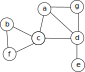

Vertices of $G$:

    ['a', 'b', 'c', 'd', 'e', 'f', 'g']

Edges of $G$:

    [{'a', 'c'}, {'d', 'a'}, {'a', 'g'}, {'c', 'b'}, {'f', 'b'}, {'d', 'c'}, {'f', 'c'}, {'d', 'e'}, {'d', 'g'}]

In [50]:
G_map = {
      "a": ["c", "d", "g"],
      "b": ["c", "f"],
      "c": ["a", "b", "d", "f"],
      "d": ["a", "c", "e", "g"],
      "e": ["d"],
      "f": ["b", "c"],
      "g": ["a", "d"]
}
G = Graph(G_map)
display(SVG(filename="small_example.svg"))
display(Markdown('''Vertices of $G$:\n
    ''' + str(G.vertices()))
        , Markdown('''Edges of $G$:\n
    ''' + str(G.edges())))

## Degrees
We then implemented methods related to *node degrees* in a graph:
- `vertex_degree`: returns the degree of a given node;
- `vertex_degrees`: returns a map $V \rightarrow \mathbb{N}$ giving the degree of each node;
- `find_isolated_vertices`: returns list of vertices with degree 0;
- `degree_sequence`: returns a tuple of all values of degrees of the nodes (with repetition) sorted in *decreasing order*;
- `density`: returns the **density** of a graph, which is the number of edges divided by the maximum possible number of edges, i.e. $$\frac{2|E|}{|V|(|V|-1)}.$$


We test these functions over $G$, over $K_5$ (the clique of size 5) and $D_5$ the disconnected graph of size 5.

In [36]:
D5 = G.no_edges(5)
K5 = G.clique(5)
display(Markdown('''Degree of vertex `d` in $G$:\n
    ''' + str(G.vertex_degree("d")))
       ,Markdown('''Degrees of vertices in $G$:\n
    ''' + str(G.vertex_degrees()))
        ,Markdown('''Degree sequence of the $G$:\n
    ''' + str(G.degree_sequence()))
       ,Markdown('''Isolated vertices of $D_5$:\n
    ''' + str(D5.find_isolated_vertices()))
       ,Markdown('''Density of $G$:\n
    ''' + str(G.density()))
       ,Markdown('''Density of $K_5$:\n
    ''' + str(K5.density()))
       ,Markdown('''Density of $D_5$:\n
    ''' + str(D5.density())))

Degree of vertex `d` in $G$:

    4

Degrees of vertices in $G$:

    {'a': 3, 'b': 2, 'c': 4, 'd': 4, 'e': 1, 'f': 2, 'g': 2}

Degree sequence of the $G$:

    (4, 4, 3, 2, 2, 2, 1)

Isolated vertices of $D_5$:

    {1, 2, 3, 4, 5}

Density of $G$:

    0.42857142857142855

Density of $K_5$:

    1.0

Density of $D_5$:

    0.0

The **Erdős–Gallai theorem** gives a sufficient and necessary condition for a given sequence $d_1\geq ...\geq d_n$ to be a valid degree sequence of some G. We implemented it in a static method `erdos_gallai` that checks if the given tuple satisfies the condition.

In [29]:
def display_EG(t):
    if G.erdos_gallai(t):
        return str(t) + " is a valid degree sequence"
    else:
        return str(t) + " is not a valid degree sequence"
display(Markdown(display_EG(G.degree_sequence()))
        , Markdown(display_EG(tuple([2,1]))))

(4, 4, 3, 2, 2, 2, 1) is a valid degree sequence

(2, 1) is not a valid degree sequence

In a graph, a **triplet** consists of three nodes that are connected by either two (open triplet) or three (closed triplet) edges. A **triangle** consists of three closed triplets, each one centered on each node of the triangle. The **global clustering coefficient** of a graph is the number of closed triplets divided by the total number of triplets. Remark that this measure is not defined over graphs with no triplet.

In [33]:
display(Markdown('''Global clustering coefficient of example graph:\n
    ''' + str(G.global_clustering_coefficient()))
       ,Markdown('''Global clustering coefficient of $K_5$:\n
    ''' + str(K5.global_clustering_coefficient())))

Global clustering coefficient of example graph:

    0.5

Global clustering coefficient of $K_5$:

    1.0

## Graph traversal
In this section, we present the function we implemented relying on graph traversal (in all these functions we used the **Breadth First Search** (BFS) traversal method.
### Connected components
We implemented a function `connected_components` which returns a map $V \rightarrow V$ assigning to each node the choosen label of its component (the label is one of the node of the component).

In order to test this function, we define a copy of our example graph in which we had another connected component, call it $G_2$.

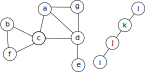

$G_2$ has 2 connected components

In [49]:
G2 = Graph(G_map)
G2.add_vertex('i')
G2.add_vertex('j')
G2.add_vertex('k')
G2.add_vertex('l')
G2.add_vertex('m')
G2.add_edge({'i','j'})
G2.add_edge({'j','k'})
G2.add_edge({'k','l'})
G2.add_edge({'l','m'})
display(SVG(filename="small_example2.svg"),
        Markdown('$G_2$ has ' + str(len(set(G2.connected_components().values()))) + ' connected components'))

### Diameter

In [5]:
print(G2.shortest_path('a','i'))
print(G2.shortest_path('a','b'))
print(G2.shortest_path('e','b'))
print(G2.shortest_path('i','m'))

inf
2
3
4


In [6]:
print(G2.diameter_component('a'))
print(G2.diameter_component('i'))
print(G2.diameter())
print(G2.biggest_component_diameter())

3
4
inf
3


In [46]:
print(G.spanning_tree())

[{'a', 'c'}, {'d', 'a'}, {'a', 'g'}, {'d', 'e'}, {'b', 'c'}, {'f', 'c'}]


In [8]:
zachary = G.from_txt('zachary_connected.txt')
random100 = G.from_txt('graph_100n_1000m.txt')
random1000 = G.from_txt('graph_1000n_4000m.txt')

In [9]:
Latex(r"""\begin{array}{|c|c|c|c|c|c|} \hline \text{Dataset} & \text{Number of vertices} & \text{Number of edges} & 
\text{Density} & \text{Diameter} & \text{Clustering coefficient} \\ \hline 
\text{Zachary} & """
+ str(len(zachary.vertices())) + r' & '+ str(len(zachary.edges())) + r""" & """
+ str(zachary.density()) + """ & """ + str(zachary.diameter()) + """ & """ + str(zachary.global_clustering_coefficient()) 
+ r""" \\\ \text{Random, } N=10^2 & """
+ str(len(random100.vertices())) + """ & """ + str(len(random100.edges())) + """ & """
+ str(random100.density()) + """ & """ + str(random100.diameter()) + """ & """ + str(random100.global_clustering_coefficient())
+ r""" \\\ \text{Random, }N=10^3 & """
+ str(len(random1000.vertices())) + """ & """ + str(len(random1000.edges())) + """ & """
+ str(random1000.density()) + """ & """ + str(random1000.diameter()) + """ & """ + str(random1000.global_clustering_coefficient()) 
+ """\\\ \hline \end{array}""")

<IPython.core.display.Latex object>